In [2]:
import pandas as pd
import requests
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

df = pd.read_excel('imgs.xlsx', nrows=10)
images_dir = 'imagenes_descargadas'
os.makedirs(images_dir, exist_ok=True)

def download_image(url, sku, index):
    img_path = os.path.join(images_dir, f"{sku}_{index}.jpg")
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(img_path, 'wb') as file:
                for chunk in response.iter_content(1024):
                    file.write(chunk)
        return img_path
    except Exception as e:
        print(f"Error descargando {url}: {e}")
        return None

imagenes_dict = {}

with ThreadPoolExecutor() as executor:
    futures = []
    for index, row in df.iterrows():
        sku = row['SKU']

        imagenes_dict.setdefault(sku, [])

        for i in range(1, 30):
            url = row.get(f'Imagen {i}')
            if pd.notna(url):
                future = executor.submit(download_image, url, sku, i)
                future.sku = sku
                futures.append(future)

    for future in as_completed(futures):
        result = future.result()
        if result:
            imagenes_dict[future.sku].append(result)
            # print(f"Descargado: {result}")


In [3]:
print(imagenes_dict)

{1067828492: ['imagenes_descargadas/1067828492_6.jpg', 'imagenes_descargadas/1067828492_4.jpg', 'imagenes_descargadas/1067828492_1.jpg', 'imagenes_descargadas/1067828492_2.jpg', 'imagenes_descargadas/1067828492_8.jpg', 'imagenes_descargadas/1067828492_5.jpg', 'imagenes_descargadas/1067828492_9.jpg', 'imagenes_descargadas/1067828492_10.jpg', 'imagenes_descargadas/1067828492_13.jpg', 'imagenes_descargadas/1067828492_3.jpg', 'imagenes_descargadas/1067828492_12.jpg', 'imagenes_descargadas/1067828492_16.jpg', 'imagenes_descargadas/1067828492_14.jpg', 'imagenes_descargadas/1067828492_17.jpg', 'imagenes_descargadas/1067828492_15.jpg', 'imagenes_descargadas/1067828492_18.jpg', 'imagenes_descargadas/1067828492_21.jpg', 'imagenes_descargadas/1067828492_19.jpg', 'imagenes_descargadas/1067828492_20.jpg', 'imagenes_descargadas/1067828492_24.jpg', 'imagenes_descargadas/1067828492_23.jpg', 'imagenes_descargadas/1067828492_22.jpg', 'imagenes_descargadas/1067828492_11.jpg', 'imagenes_descargadas/106782

In [3]:
from PIL import Image

def preprocesar_imagen(img_path, size=(224, 224)):
    """Redimensiona la imagen a un tamaño uniforme."""
    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize(size)
        return img
    except Exception as e:
        # print(f"Error procesando {img_path}: {e}")
        return None

imagenes_procesadas = {sku: [preprocesar_imagen(img) for img in paths] for sku, paths in imagenes_dict.items()}

In [4]:
from transformers import CLIPProcessor, CLIPModel
import torch

# Cargar el modelo CLIP y el procesador
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def obtener_embedding(imagen):
    """Genera el embedding de una imagen."""
    inputs = processor(images=imagen, return_tensors="pt")
    outputs = model.get_image_features(**inputs)

    return outputs / outputs.norm(dim=-1, keepdim=True)

embeddings_dict = {sku: [obtener_embedding(img) for img in imgs if img] for sku, imgs in imagenes_procesadas.items()}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
print(embeddings_dict[1093284182])

[tensor([[-4.0594e-02,  9.3978e-03,  2.7465e-02,  1.9023e-02, -2.6205e-02,
         -4.9570e-03,  1.3521e-02,  4.9633e-02,  1.1271e-02,  6.3862e-03,
          4.3183e-02,  3.2912e-02,  4.6232e-02, -2.8126e-02, -7.2629e-03,
         -1.1011e-02,  9.2719e-02, -2.5629e-02,  8.9060e-03, -5.6875e-02,
         -1.9739e-02, -1.2082e-02, -3.4596e-03, -5.6797e-02, -1.6948e-02,
          2.2044e-02, -1.3748e-02, -4.2415e-02, -2.2656e-03,  2.7861e-04,
         -2.3312e-02, -3.6115e-02,  2.9889e-02, -1.8675e-03, -5.6150e-02,
         -3.9946e-02, -2.3808e-02, -2.9350e-02, -8.8114e-03,  2.5343e-02,
         -4.1335e-02,  1.4251e-02,  6.6568e-02,  5.7891e-03,  2.8881e-03,
         -7.7095e-02,  9.6788e-03,  2.6777e-02,  3.6794e-02, -3.0171e-02,
          7.3248e-02,  2.6912e-02, -2.3336e-02,  4.3536e-04,  5.4920e-03,
          1.9819e-02,  3.6449e-02,  5.2390e-02,  5.9205e-02,  6.4577e-02,
          4.2071e-02, -3.6401e-03,  3.3867e-02,  1.5591e-03,  7.5968e-04,
         -1.0344e-02,  2.8423e-03, -6

In [5]:
import pandas as pd

def crear_csv(embeddings_dict, imagenes_dict):
    data = []
    for sku in embeddings_dict:
        json = {}

        json['sku'] = sku

        # Convertir tensor a lista, asegurando que sea un tensor de PyTorch o similar
        json['embedding'] = [em.tolist() for em in embeddings_dict[sku]]  # Asegúrate de que el tensor tenga el método .tolist()

        json['imagenes'] = list(imagenes_dict[sku])
        data.append(json)

    df = pd.DataFrame(data)
    df.to_csv('db.csv', index=False)

# Llamada a la función
crear_csv(embeddings_dict, imagenes_dict)



In [7]:
from sklearn.metrics.pairwise import cosine_similarity

def calcular_similares(image):
    preprocesada = preprocesar_imagen(image)
    embedding = obtener_embedding(preprocesada)

    embedding = embedding.detach().numpy()
    similares = []
    for sku in embeddings_dict:
        index = 0
        for emb in embeddings_dict[sku]:
            index += 1
            similitud = cosine_similarity(embedding, emb.detach().numpy())
            if similitud[0][0] > 0.68:
                similares.append((sku, index, similitud[0][0]))
    return similares

imagen = "Audifonos.jpg"

lista_similares = calcular_similares(imagen)

lista_similares

[(1097617844, 20, 0.68402076),
 (1093284182, 1, 0.7900189),
 (1093284182, 2, 0.80041444),
 (1093284182, 3, 0.78675985),
 (1093284182, 4, 0.7462684),
 (1093284182, 5, 0.85769224),
 (1093284182, 6, 0.80041444),
 (1093284182, 7, 0.85769224),
 (1093284182, 8, 0.7579212),
 (1093284182, 9, 0.7579212),
 (1093284182, 10, 0.7462684),
 (1093284182, 11, 0.7895671),
 (1148074235, 1, 0.71925956),
 (1148074235, 8, 0.71744),
 (1148074235, 10, 0.68856406),
 (1148074235, 11, 0.6892081),
 (1148074235, 12, 0.6990133),
 (1073078431, 5, 0.6962568),
 (1073078431, 7, 0.76263404),
 (1073078431, 8, 0.6962568),
 (1073078431, 9, 0.76263404),
 (1073078431, 15, 0.7079014),
 (1073078431, 16, 0.7079014),
 (1118150312, 1, 0.70830595),
 (1118150312, 5, 0.7769971),
 (1118150312, 7, 0.70830595),
 (1118150312, 8, 0.69382215),
 (1118150312, 9, 0.6911296),
 (1118150312, 12, 0.7769971),
 (1118150312, 13, 0.778867),
 (1118150312, 14, 0.778867),
 (1118150312, 15, 0.6927986),
 (1118150312, 16, 0.6927986),
 (1118150312, 17, 0.6

FileNotFoundError: [Errno 2] No such file or directory: '/content/imagenes_descargadas/1093284182_4.jpg'

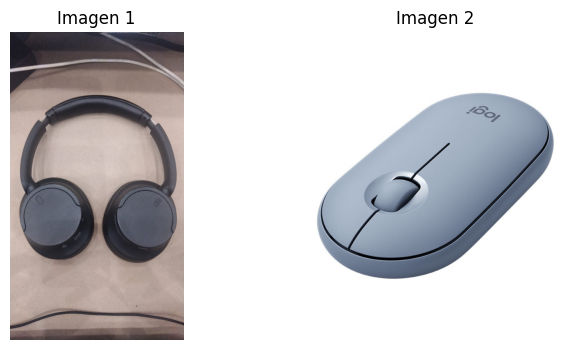

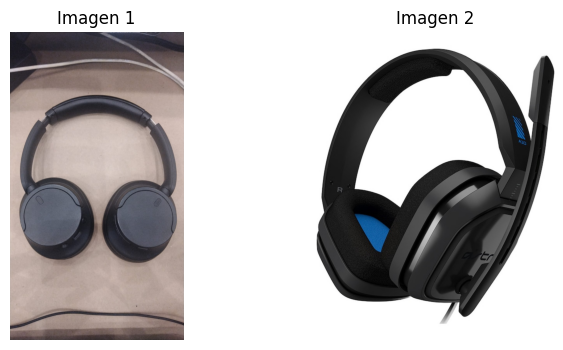

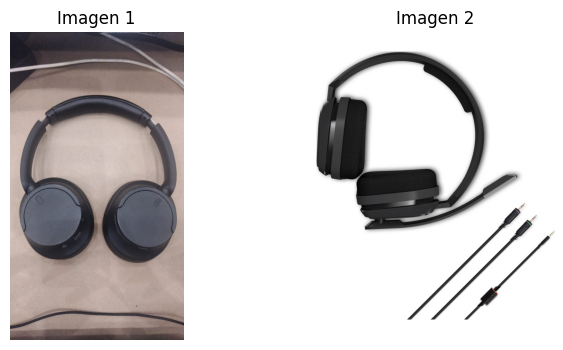

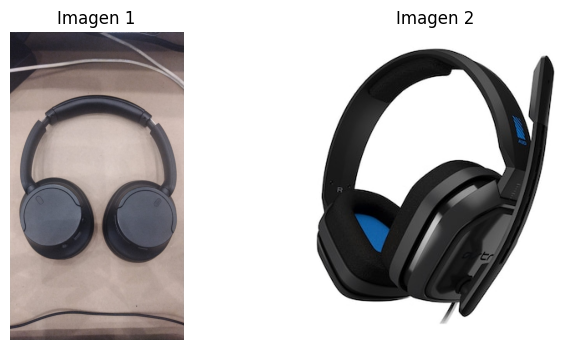

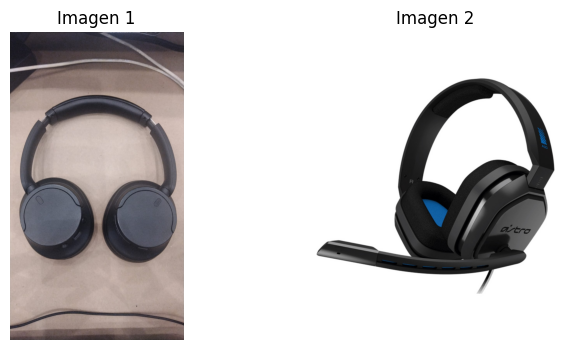

In [8]:
import matplotlib.pyplot as plt

def visualizar_similares(lista_similares,imagenes_dict,imagen):
    imagenes_sku = imagenes_dict.get(sku, [])

    for item in lista_similares:
        img1 = Image.open(imagen)

        # print(f"SKU: {item[0]}, Index: {item[1]}, Similitud: {item[2]}")

        ruta = imagenes_dict[item[0]][item[1]-1]
        img2 = Image.open(ruta)

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        axes[0].imshow(img1)
        axes[0].axis('off')
        axes[0].set_title(f"Imagen 1")

        axes[1].imshow(img2)
        axes[1].axis('off')
        axes[1].set_title(f"Imagen 2")

visualizar_similares(lista_similares,imagenes_dict,imagen)

In [ ]:
# import matplotlib.pyplot as plt


# # Calcular similitudes entre los embeddings generados
# for sku, embeddings in embeddings_dict.items():
#     if embeddings is not None:
#         similares = calcular_similares(embeddings)
#         print(f"Similitudes para SKU {sku}: {similares}")

# # Graficar número de imágenes descargadas por SKU
# skus = list(imagenes_dict.keys())
# num_imgs = [len(imagenes_dict[sku]) for sku in skus]

# plt.bar(skus, num_imgs)
# plt.xlabel("SKU")
# plt.ylabel("Número de imágenes descargadas")
# plt.title("Imágenes descargadas por SKU")
# plt.xticks(rotation=90)
# plt.show()